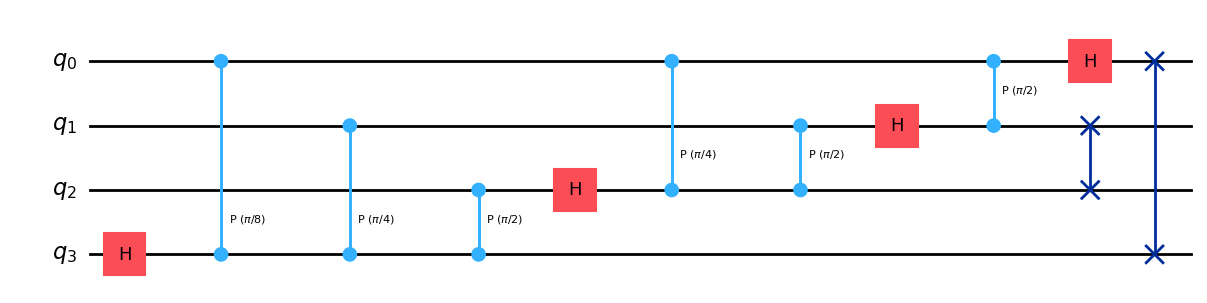

In [6]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from numpy import pi
import numpy as np

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit    
# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

In [1]:
import qiskit
from qiskit_aer import AerSimulator, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import time
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, transpile
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService, IBMBackend, Sampler
from qiskit.providers.jobstatus import JobStatus

In [8]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

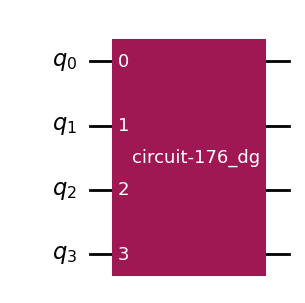

In [9]:
qc = QuantumCircuit(4)
inverse_qft(qc,4)
qc.draw('mpl')

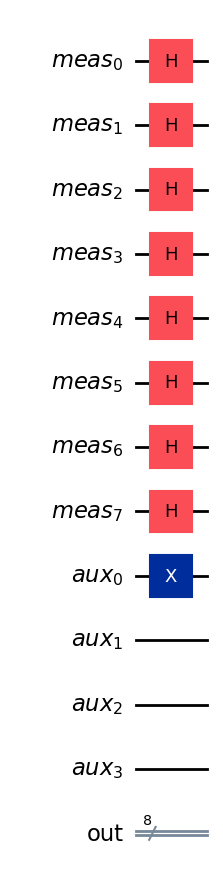

In [2]:
# 測定用ビットの数（位相推定の精度）
n_meas = 8
# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# Uを作用させる作業用レジスタ
qreg_aux = QuantumRegister(4, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作成
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)
# 測定用レジスタ全てにHadamard変換
qc.h(qreg_meas)
# 作業用レジスタにPauliX
qc.x(qreg_aux[0])

qc.draw('mpl')

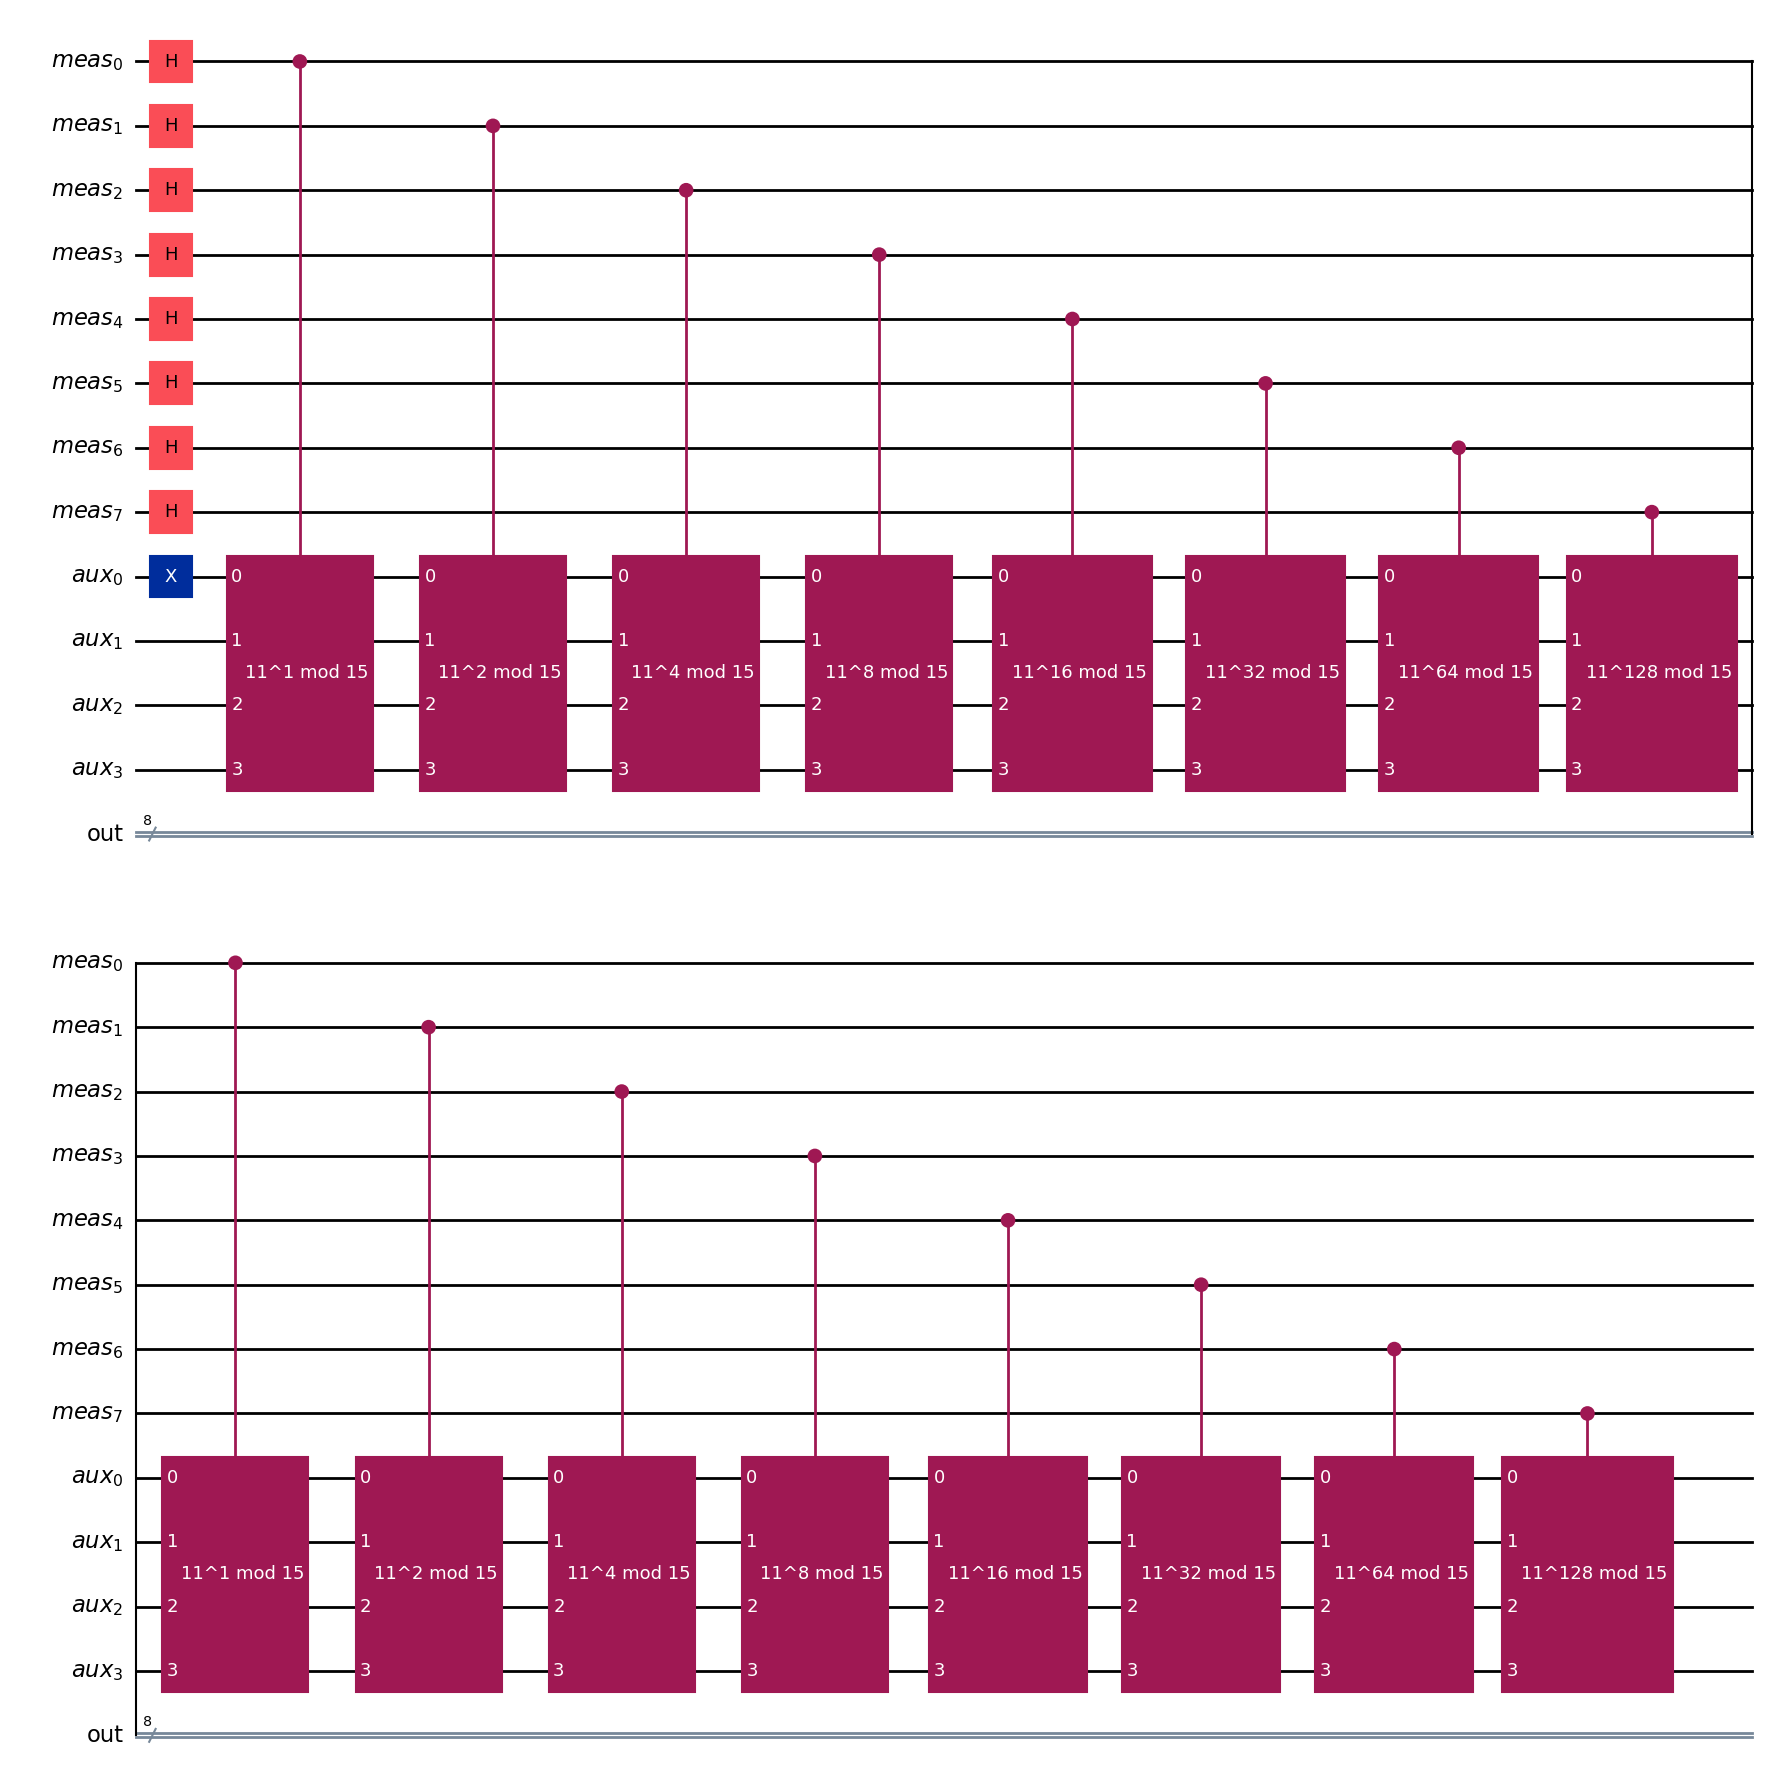

In [4]:
# 15と互いに素な数
a = 11

def c_amod15(a, l):
    """mod 15による制御ゲート"""

    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2, 4, 7, 8, 11, or 13")

    U = QuantumCircuit(4)

    if a == 2:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a == 4:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a == 8:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)
            
    if a in [2, 13]:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a in [4, 11]:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a in [8, 7]:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    if a in [7, 11, 13]:
        U.x([0, 1, 2, 3])


    # Uを2^l回繰り返す
    U_power = U.repeat(2 ** l)

    # U_powerをゲートに変換
    gate = U_power.to_gate()
    gate.name = f"{a}^{2 ** l} mod 15"

    # gateを制御ゲートに変換
    c_gate = gate.control()
    return c_gate

#制御Uゲートを適用
for l, ctrl in enumerate(qreg_meas):
    qc.append(c_amod15(a, l), qargs=([ctrl] + qreg_aux[:]))

qc.draw('mpl')

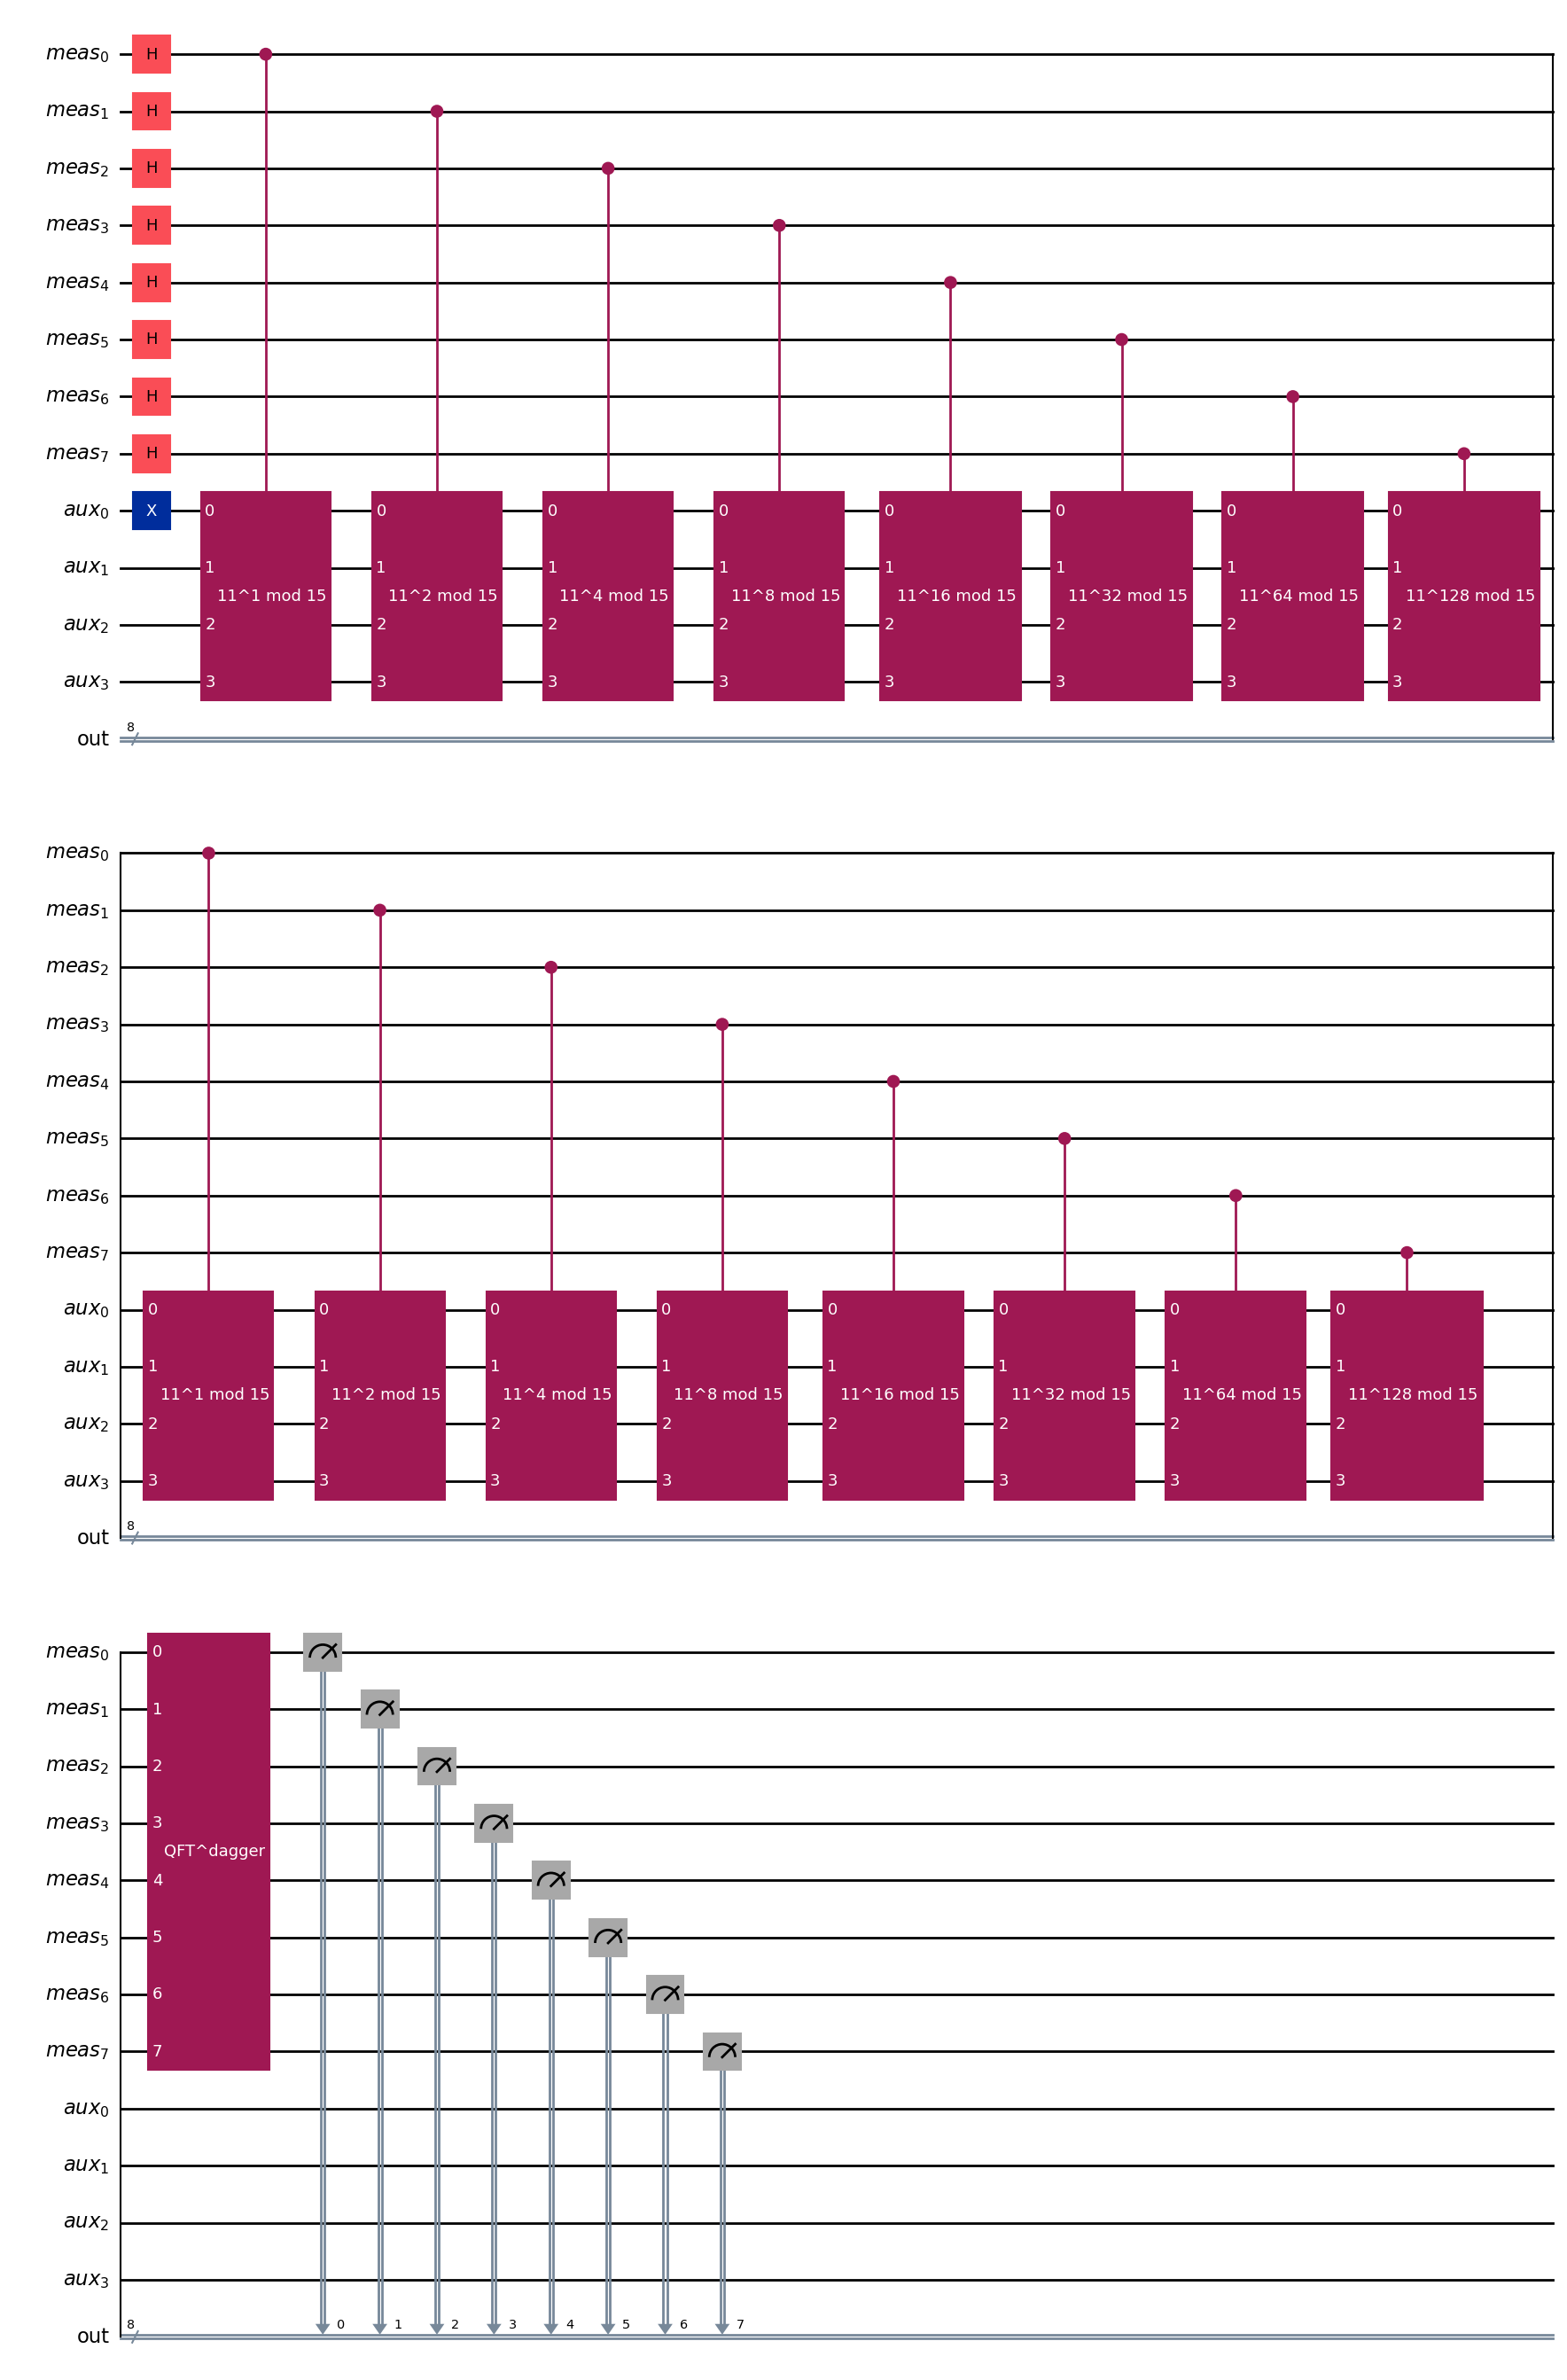

In [5]:
def qft_dagger(qreg):
    """逆量子フーリエ変換用の回路"""
    qc = QuantumCircuit(qreg)

    # 1. Qubitのスワップ (反転)
    # 量子レジスタの最初の半分と最後の半分を入れ替えます。
    for j in range(len(qreg) // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    # 2. 制御位相ゲートとHadamardゲートの適用
    # 各qubitに対して、制御位相ゲート（cp）とHadamardゲートを適用します。
    for itarg in range(len(qreg)):
        for ictrl in range(itarg):
            # 制御位相ゲートを適用します。位相は2の累乗に依存します。
            power = ictrl - itarg - 1
            qc.cp(-2.0 * np.pi * (2 ** power), qreg[ictrl], qreg[itarg])

        # Hadamardゲートをターゲットqubitに適用します。
        qc.h(qreg[itarg])

    qc.name = "QFT^dagger"
    return qc
# 逆QFTを適用
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)
    

    
# 回路を測定
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

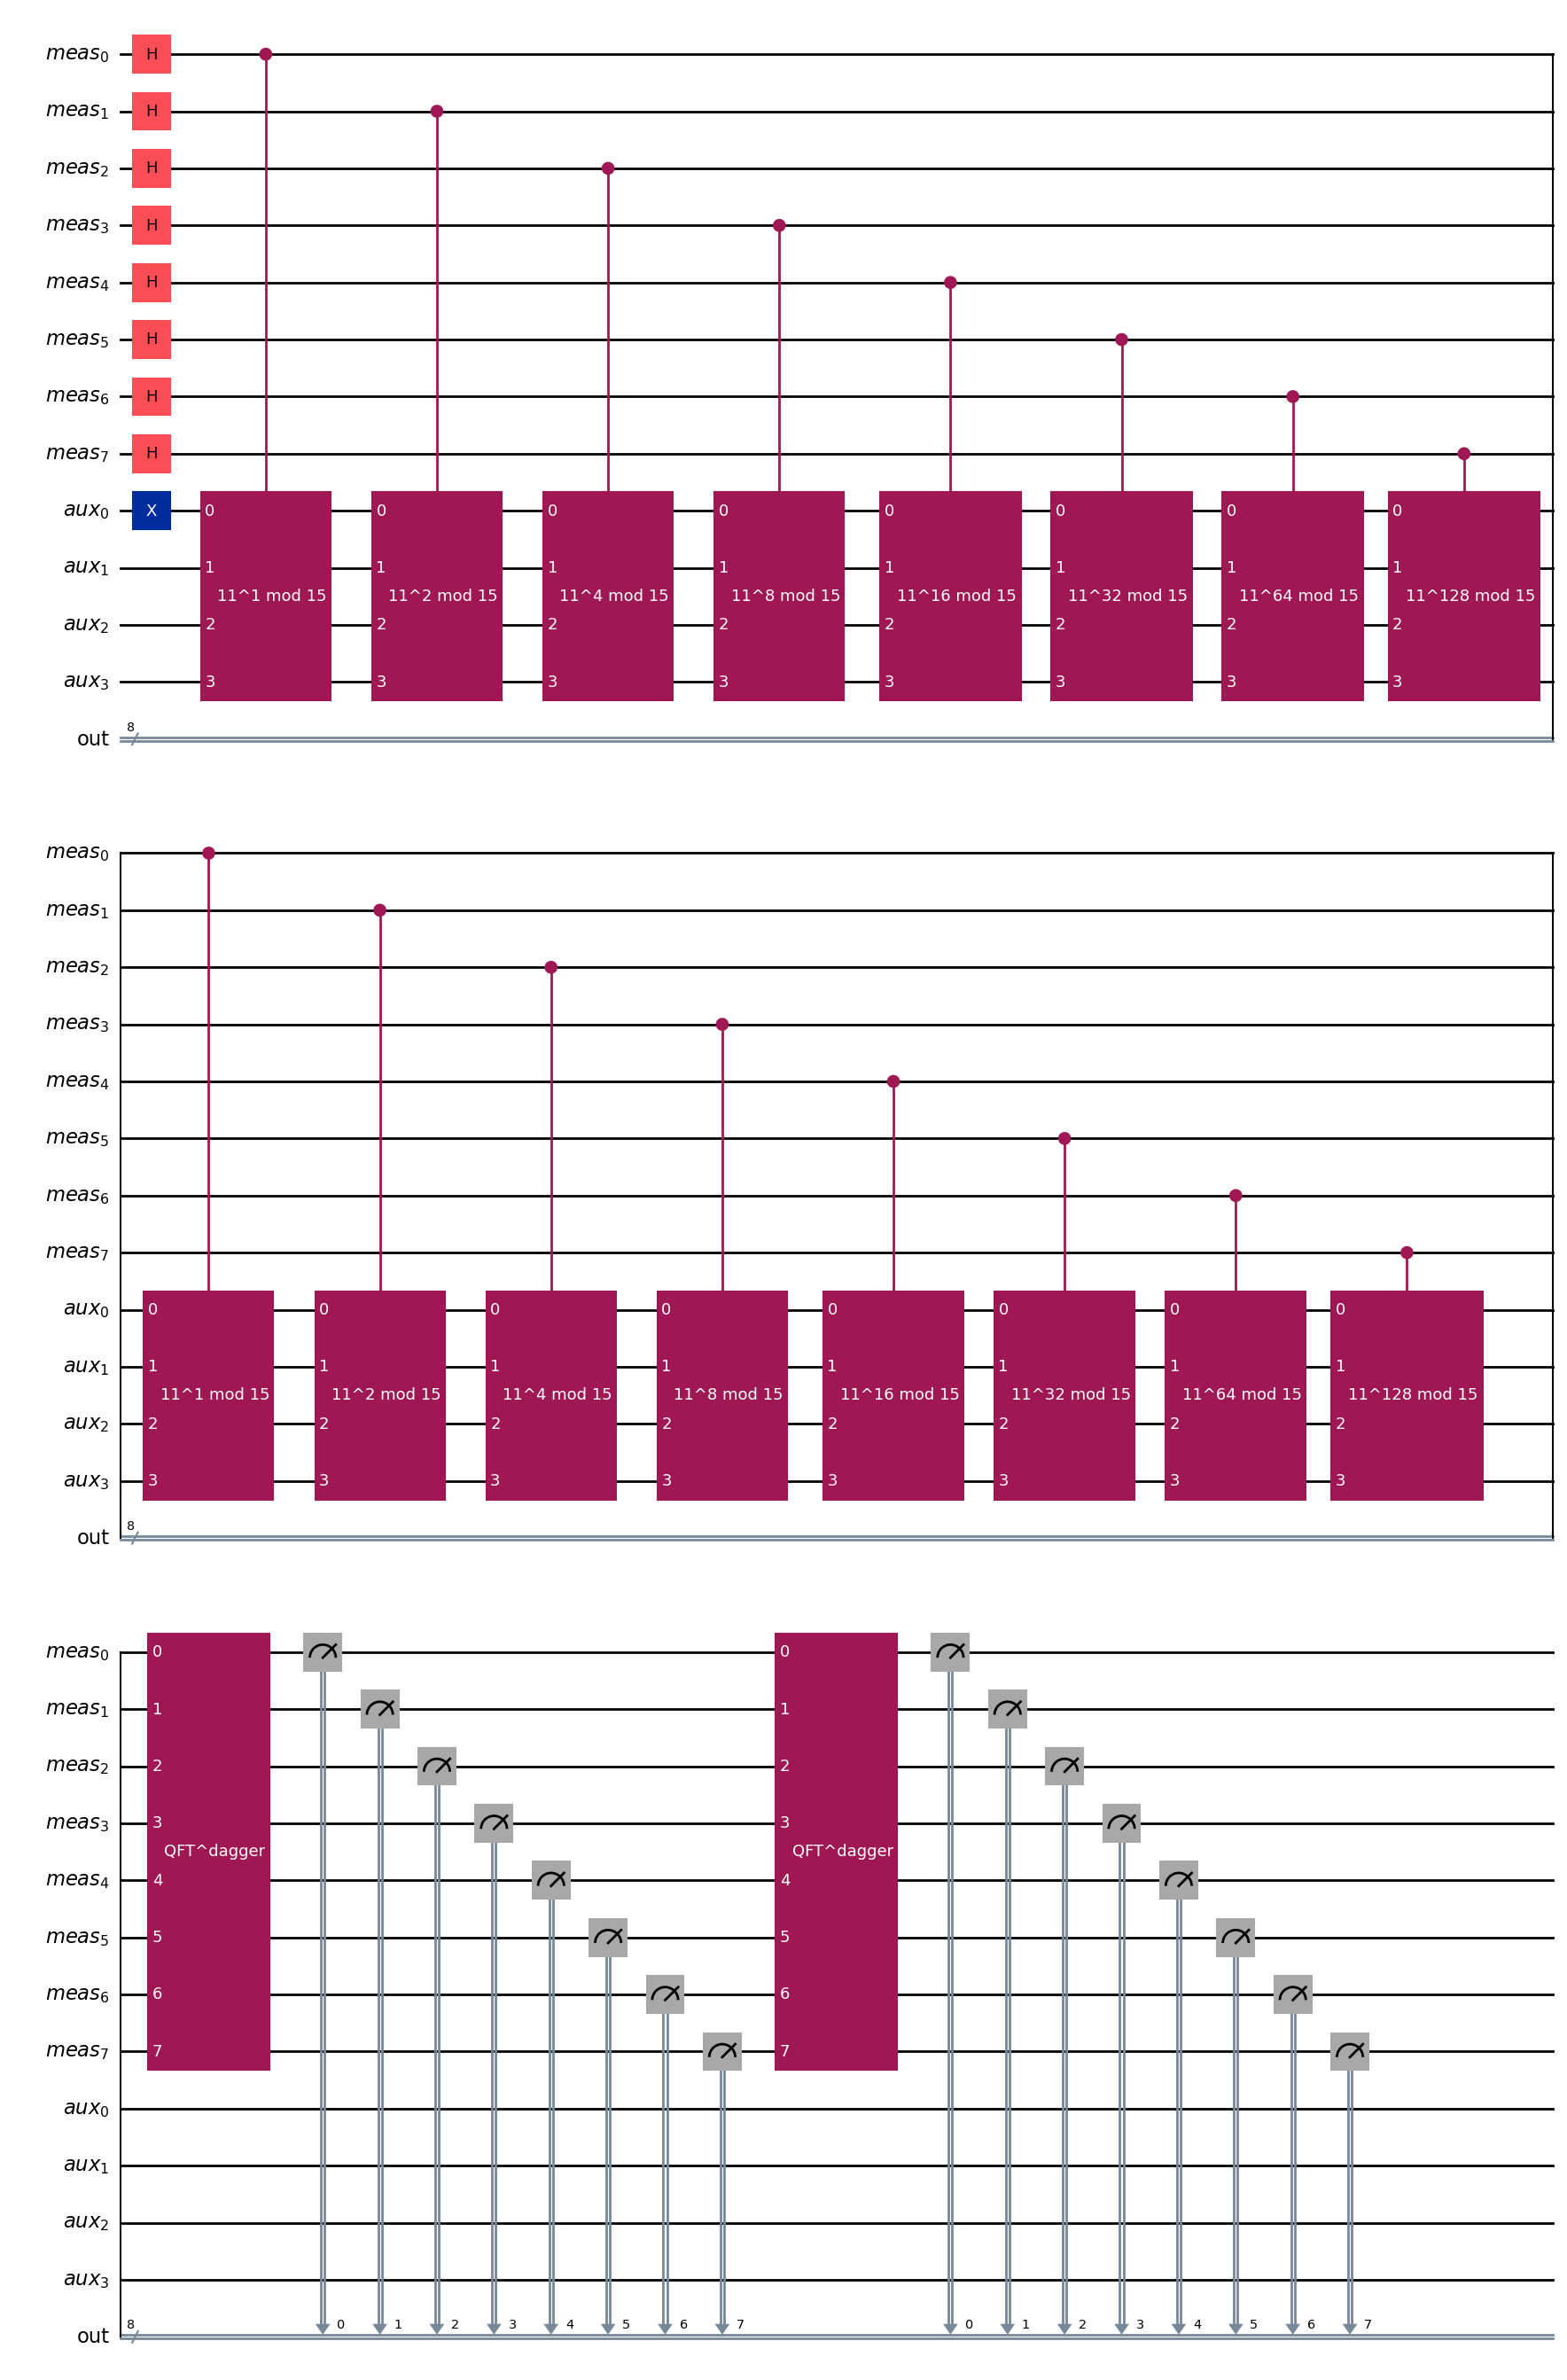

In [6]:
def qft_dagger(qreg):
    """逆量子フーリエ変換用の回路"""
    qc = QuantumCircuit(qreg)

    # 1. Qubitのスワップ (反転)
    # 量子レジスタの最初の半分と最後の半分を入れ替えます。
    for j in range(len(qreg) // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    # 2. 制御位相ゲートとHadamardゲートの適用
    # 各qubitに対して、制御位相ゲート（cp）とHadamardゲートを適用します。
    for itarg in range(len(qreg)):
        for ictrl in range(itarg):
            # 制御位相ゲートを適用します。位相は2の累乗に依存します。
            power = ictrl - itarg - 1
            qc.cp(-2.0 * np.pi * (2 ** power), qreg[ictrl], qreg[itarg])

        # Hadamardゲートをターゲットqubitに適用します。
        qc.h(qreg[itarg])

    qc.name = "QFT^dagger"
    return qc

# 逆QFTを適用
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)

# 回路を測定
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')
